In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arnaud58/flickrfaceshq-dataset-ffhq")

print("Path to dataset files:", path)

100%|██████████| 19.5G/19.5G [04:38<00:00, 75.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arnaud58/flickrfaceshq-dataset-ffhq/versions/1


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Reshape, Concatenate, LeakyReLU, BatchNormalization, Dropout, Conv2DTranspose
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

#load the dataset


def load_dataset(path):
    images = np.random.randn(1000, 64, 64, 3)  # Dummy data
    labels = np.random.randint(0, 8, 1000)     # Dummy labels
    images = (images - 127.5) / 127.5          # Normalize to [-1, 1]
    return images, labels

     # Load Data
    images, labels = load_dataset('/root/.cache/kagglehub/datasets/arnaud58/flickrfaceshq-dataset-ffhq/versions/1')




In [ ]:
#Generator Model
def build_generator(latent_dim, num_classes, img_shape):
    label_input = Input(shape=(1,), name="label_input")
    noise_input = Input(shape=(latent_dim,), name="noise_input")

    label_embedding = Dense(latent_dim)(label_input)
    merged_input = Concatenate()([noise_input, label_embedding])

    x = Dense(256 * 8 * 8, activation="relu")(merged_input)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(32, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    img_output = Conv2DTranspose(img_shape[-1], kernel_size=4, strides=1, padding="same", activation="tanh")(x)

    latent_dim = 100
    num_classes = 8
    img_shape = (64, 64, 3)

    return Model([noise_input, label_input], img_output, name="generator")
    print("Generator Summary:")
    generator= build_generator(latent_dim, num_classes, img_shape).summary()

In [ ]:
#Discriminator model with FT using VGG19 Model
def build_transfer_learning_discriminator(input_shape, num_classes):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    for layer in vgg.layers:
        layer.trainable = False

    img_input = Input(shape=input_shape, name="image_input")
    label_input = Input(shape=(1,), name="label_input")

    vgg_features = vgg(img_input)
    flat_features = Flatten()(vgg_features)

    label_embedding = Dense(np.prod(input_shape))(label_input)
    label_embedding = LeakyReLU(alpha=0.2)(label_embedding)

    merged = Concatenate()([flat_features, label_embedding])

    x = Dense(128)(merged)
    x = LeakyReLU(alpha=0.2)(x)
    validity = Dense(1, activation="sigmoid", name="validity")(x)

    latent_dim = 100
    num_classes = 8
    img_shape = (64, 64, 3)

    return Model([img_input, label_input], validity, name="discriminator")
    discriminator = build_transfer_learning_discriminator(img_shape, num_classes)
    discriminator.summary()

In [ ]:
#cGAN Model
def build_cgan(generator, discriminator, latent_dim, ttur_gen_lr, ttur_disc_lr): # Added ttur_gen_lr as an argument
    discriminator.compile(optimizer=Adam(ttur_disc_lr, 0.5), loss="binary_crossentropy", metrics=["accuracy"])
    discriminator.trainable = False

    noise_input = Input(shape=(latent_dim,), name="noise_input")
    label_input = Input(shape=(1,), name="label_input")
    generated_img = generator([noise_input, label_input])
    validity = discriminator([generated_img, label_input])

    cgan = Model([noise_input, label_input], validity, name="cGAN")
    cgan.compile(optimizer=Adam(ttur_gen_lr, 0.5), loss="binary_crossentropy") # Now using the correct learning rate
    return cgan

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Epoch: 1/10, Discriminator Loss: 0.7026697397232056, Generator Loss: [array(0.702246, dtype=float32), array(0.702246, dtype=float32), array(0.5, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/

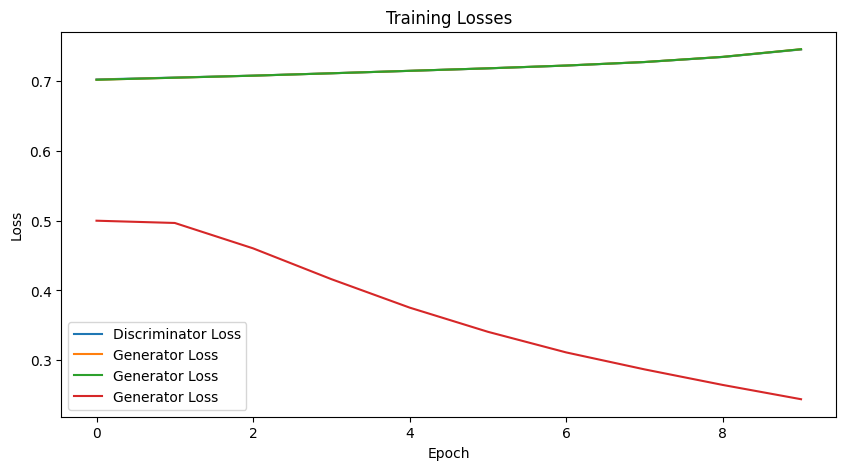

In [ ]:
#Training Loop


import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Create a data pipeline
def preprocess_data(images, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Save generated images for monitoring
def save_generated_images(epoch, generator, latent_dim, num_classes, save_dir="generated_images"):
    os.makedirs(save_dir, exist_ok=True)
    noise = np.random.normal(0, 1, (num_classes, latent_dim))
    labels = np.arange(num_classes)  # One image per class
    generated_images = generator.predict([noise, labels])
    generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)

    # Plot and save images
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
    for i, img in enumerate(generated_images):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.savefig(f"{save_dir}/epoch_{epoch}.png")
    plt.close()

# Train function with monitoring and visualization
def train(generator, discriminator, cgan, images, labels, epochs, batch_size, latent_dim, num_classes):
    dataset = preprocess_data(images, labels, batch_size)

    history = {'d_loss': [], 'g_loss': []}

    for epoch in range(10):
        for real_images, real_labels in dataset:
            batch_size_actual = real_images.shape[0]

            # Generate fake images
            noise = np.random.normal(0, 1, (batch_size_actual, latent_dim))
            fake_images = generator.predict([noise, real_labels])

            # Validity labels
            valid = np.ones((batch_size_actual, 1))
            fake = np.zeros((batch_size_actual, 1))

            # Train Discriminator
            d_loss_real = discriminator.train_on_batch([real_images, real_labels], valid)
            d_loss_fake = discriminator.train_on_batch([fake_images, real_labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            random_noise = np.random.normal(0, 1, (batch_size_actual, latent_dim))
            random_labels = np.random.randint(0, num_classes, batch_size_actual)
            g_loss = cgan.train_on_batch([random_noise, random_labels], valid)

        # Log losses
        history['d_loss'].append(d_loss[0])  # Access the first element if d_loss is a list
        history['g_loss'].append(g_loss)


        print(f"Epoch: {epoch + 1}/{epochs}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")
        # Save images at regular intervals
        if (epoch + 1) % 5 == 0:
            save_generated_images(epoch + 1, generator, latent_dim, num_classes)

    # Plot the training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['d_loss'], label="Discriminator Loss")
    plt.plot(history['g_loss'], label="Generator Loss")
    plt.title("Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    latent_dim = 100
    num_classes = 8
    img_shape = (64, 64, 3)
    ttur_gen_lr = 0.0001
    ttur_disc_lr = 0.0004
    batch_size = 64
    epochs = 10

    # Load Dataset
    images, labels = load_dataset('/root/.cache/kagglehub/datasets/nelgiriyewithana/emotions/versions/1')


    generator = build_generator(latent_dim, num_classes, img_shape)
    discriminator = build_transfer_learning_discriminator(img_shape, num_classes)
    cgan = build_cgan(generator, discriminator, latent_dim, ttur_gen_lr, ttur_disc_lr) # Passing ttur_gen_lr and ttur_disc_lr

    # Train Models
    train(generator, discriminator, cgan, images, labels, epochs, batch_size, latent_dim, num_classes)




In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from scipy.stats import entropy

# Function to preprocess and resize images for InceptionV3
def preprocess_images(images):
    # Resize to (299, 299, 3) for InceptionV3
    resized_images = tf.image.resize(images, (299, 299)).numpy()
    # Normalize to [0, 1] for InceptionV3
    return (resized_images + 1) / 2.0

# Function to calculate the Inception Score (IS)
def calculate_inception_score(generator, latent_dim, num_classes, n_images=5000, batch_size=128):
    """
    Calculate the Inception Score for a GAN model.

    Args:
    - generator: The trained generator model.
    - latent_dim: Latent space dimension used by the generator.
    - num_classes: Number of classes for the conditional GAN.
    - n_images: Total number of images to generate for evaluation.
    - batch_size: Batch size for generating images.

    Returns:
    - mean IS score and standard deviation.
    """
    # Load pre-trained InceptionV3 model
    inception_model = InceptionV3(include_top=True, weights="imagenet")
    inception_model = Model(inputs=inception_model.input, outputs=inception_model.get_layer("avg_pool").output)

    # Generate images and predictions in batches
    n_batches = n_images // batch_size
    preds = []

    for _ in range(n_batches):
        # Generate random noise and labels
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        labels = np.random.randint(0, num_classes, batch_size)

        # Generate images using the trained generator
        generated_images = generator.predict([noise, labels], verbose=0)
        preprocessed_images = preprocess_images(generated_images)

        # Get InceptionV3 predictions
        preds.append(inception_model.predict(preprocessed_images, verbose=0))

    preds = np.concatenate(preds, axis=0)  # Combine all predictions

    # Compute probabilities and the Inception Score
    p_y = np.mean(preds, axis=0)
    kl_div = entropy(preds, p_y, axis=1)
    is_scores = np.exp(np.mean(kl_div))

    return is_scores

# Example Usage
if __name__ == "__main__":
    latent_dim = 100  # Latent space dimension of the generator
    num_classes = 8   # Number of classes in your GAN
    n_images = 5000   # Total number of images for evaluation
    batch_size = 128  # Batch size for generating images

    # Ensure generator is trained before calculating IS
    inception_score = calculate_inception_score(generator, latent_dim, num_classes, n_images, batch_size)
    print(f"Inception Score: {inception_score:.4f}")


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Inception Score: 1.1190


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Function to evaluate discriminator accuracy
def evaluate_discriminator_accuracy(generator, discriminator, images, labels, latent_dim, batch_size, num_samples=1000):
    """
    Evaluate the accuracy of the discriminator.

    Args:
    - generator: The trained generator model.
    - discriminator: The trained discriminator model.
    - images: Real images from the dataset.
    - labels: Corresponding labels for the real images.
    - latent_dim: Latent space dimension used by the generator.
    - batch_size: Batch size for evaluation.
    - num_samples: Number of samples to evaluate.

    Returns:
    - Accuracy of the discriminator on real vs. fake classification.
    """
    # Sample real images and labels
    idx = np.random.randint(0, images.shape[0], num_samples)
    real_images = images[idx]
    real_labels = labels[idx]

    # Generate fake images and labels
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    fake_labels = np.random.randint(0, num_classes, num_samples)
    fake_images = generator.predict([noise, fake_labels])

    # Combine real and fake samples
    combined_images = np.concatenate([real_images, fake_images], axis=0)
    combined_labels = np.concatenate([real_labels, fake_labels], axis=0)

    # Assign real (1) and fake (0) validity labels
    true_validity = np.concatenate([np.ones((num_samples, 1)), np.zeros((num_samples, 1))], axis=0)

    # Get discriminator predictions
    predicted_validity = discriminator.predict([combined_images, combined_labels])

    # Convert predictions to binary classification
    predicted_binary = (predicted_validity > 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(true_validity, predicted_binary)
    return accuracy


# Example usage
if __name__ == "__main__":
    latent_dim = 100
    num_classes = 8
    batch_size = 64
    num_samples = 1000

    # Load Dataset
    images, labels = load_dataset('/root/.cache/kagglehub/datasets/nelgiriyewithana/emotions/versions/1')

    # Evaluate discriminator accuracy
    accuracy = evaluate_discriminator_accuracy(generator, discriminator, images, labels, latent_dim, batch_size, num_samples)
    print(f"Discriminator Accuracy: {accuracy * 100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step
Discriminator Accuracy: 5.00%
